In [28]:
# This program compares a measured wind field at carriel sur weather station with the simulated wind 
# field using the sea breeze model - Claudio Iturra, 2024.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import SeaBreezeModel as sbm
# import taylorDiagram as dia
from scipy.optimize import curve_fit 
import scipy.interpolate as interp

plt.close("all")

In [30]:
# load  Observations
# =============================================================================
data = pd.read_csv('data.csv',sep=',',header=0)

u_vel = data['u0[m/s]']
v_vel = data['v0[m/s]']
dpdx  = data['dpdx[Pa/km]']
dpdy  = data['dpdy[Pa/km]']

hours = np.arange(len(u_vel))
dpdx_mean = np.mean(dpdx)

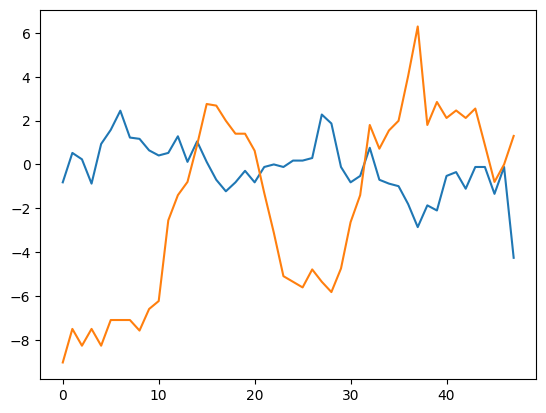

In [32]:
plt.figure()
plt.plot(hours,dpdx)
plt.plot(hours,u_vel)

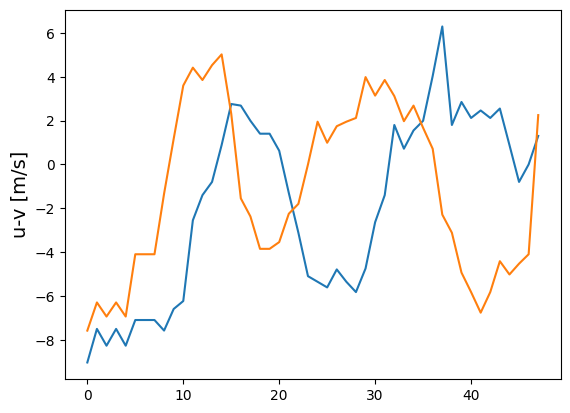

In [27]:
plt.figure()
plt.plot(hours,u_vel, label = 'u (numerical solution) euler')
plt.ylabel('u-v [m/s]', fontsize=14) # label along x-axes
plt.plot(hours,v_vel, label = 'u (numerical solution) euler')

Text(0, 0.5, 'dpdx-dpdy[Pa/km]')

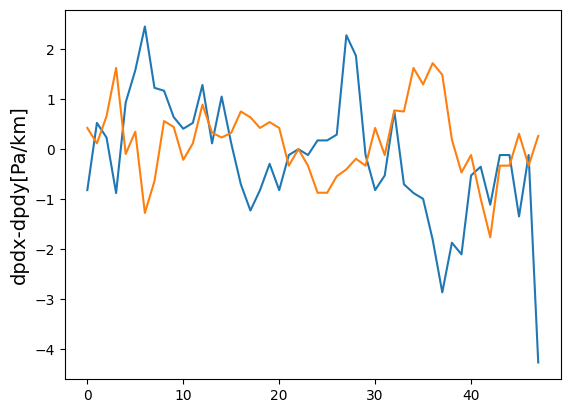

In [15]:
plt.figure()
plt.plot(hours,dpdx, label = 'u (numerical solution) euler')
plt.plot(hours,dpdy, label = 'u (numerical solution) euler')
plt.ylabel('dpdx-dpdy[Pa/km]', fontsize=14) # label along x-axes

In [16]:
# find linear fit to the observed - mean pressure gradient
def linfit(x,a,b):
    return a*x +b

In [17]:
poptlin,pcovlin = curve_fit(linfit,hours, dpdx - dpdx_mean)

dpdx_synoptic = linfit(hours,poptlin[0],poptlin[1]) + dpdx_mean
dpdx_detrend = dpdx - dpdx_synoptic

# interpolation function for the y pressure gradient
f_dpdy = interp.interp1d(np.arange(dpdy.size),dpdy)


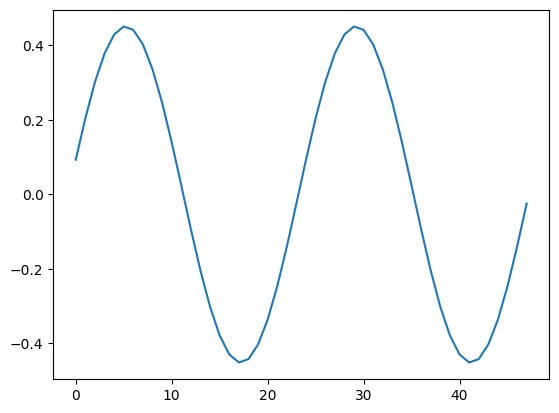

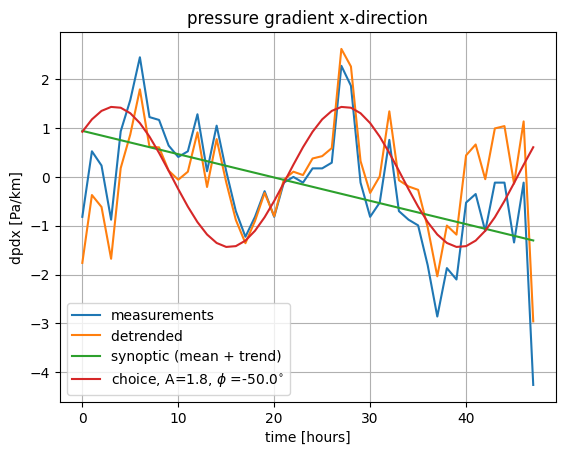

In [18]:
#%% =============================================================================
# Estimate A and phi
# =============================================================================

# fit function for daily variations of detrended pressure gradient
def func(hours,A,phase):
    return A/sbm.rho*np.cos(2*np.pi*hours/24.+ phase)

A_guess = 1.9
phase_guess = 0.

popt,pcov = curve_fit(func,hours, dpdx_detrend, p0 = [A_guess,phase_guess],
                      bounds=([0,-np.pi],[5,np.pi])) 

# save estimtas for simulations with the simple idealised model
A_estimate_ideal = popt[0] 
phase_estimate_ideal = popt[1]

plt.plot(hours,func(hours,A_estimate_ideal,phase_estimate_ideal),
         label="fit, A="+ str(round(A_estimate_ideal,2)) + 
         ", $\phi$ ="+str(round(phase_estimate_ideal*180/np.pi,2))+"$^{\circ}$")

# chosen estimates for the "more sophisticated model"
A_estimate = 1.8
phase_estimate = -50. /180 * np.pi


plt.subplots()
plt.xlabel("time [hours]")
plt.ylabel("dpdx [Pa/km]")
plt.title("pressure gradient x-direction")
plt.plot(hours,dpdx,label="measurements")
plt.plot(hours,dpdx_detrend, label="detrended ")
plt.plot(hours,dpdx_synoptic,label="synoptic (mean + trend)")
 
plt.plot(hours,func(hours,A_estimate,phase_estimate),
         label="choice, A="+ str(round(A_estimate,2)) +
         ", $\phi$ ="+str(round(phase_estimate*180/np.pi,2))+"$^{\circ}$")

plt.legend()
plt.grid()

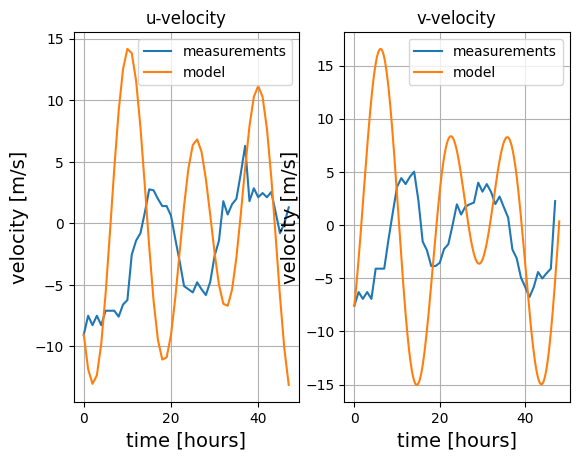

In [19]:
# First guess model
# =============================================================================
# define integration method
dt = 100.
tmax_h = 48 
corrector_step = False
method = "rk4"

integrator = sbm.integration(dt,tmax_h,corrector_step,method)

# define model
lat = -36
A = A_estimate_ideal/1000.   
phase = phase_estimate_ideal 
gamma = 0

# time array
hours_arr = np.linspace(0.,47.,integrator.iters,endpoint=True)

# array of the pressure gradient
dpdx_synoptic = linfit(hours_arr,poptlin[0],poptlin[1]) + dpdx_mean
dpdy = f_dpdy(hours_arr)

# make a model instance with the chosen settings
sb = sbm.seaBreezeModel(lat,A,phase,gamma,dpdx_synoptic/1000., dpdy/1000.)

# initial values for the wind
u_init = u_vel[0]
v_init = v_vel[0]

# integrate the model
integrator.integrate2D(sb.fIdeal,sb.ug, sb.vg, u_init,v_init)

# store variabels
u_model,v_model,time_model = integrator.u,integrator.v, integrator.time    

# =============================================================================
# Plot results
# =============================================================================

fig, ax = plt.subplots(1,2)
ax[0].set_title("u-velocity")
ax[0].plot(hours,u_vel,label="measurements")
ax[0].plot(time_model[::36]/3600.,u_model[::36],label="model")
ax[0].set_xlabel('time [hours]', fontsize=14) # label along x-axes
ax[0].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
ax[0].legend()
ax[0].grid()

ax[1].set_title("v-velocity")
ax[1].plot(hours,v_vel,label="measurements")
ax[1].plot(time_model/3600.,v_model,label="model")
ax[1].set_xlabel('time [hours]', fontsize=14) # label along x-axes
ax[1].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
ax[1].legend()
ax[1].grid()

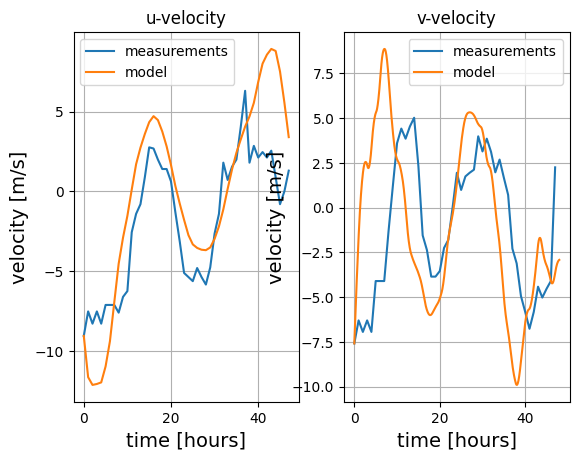

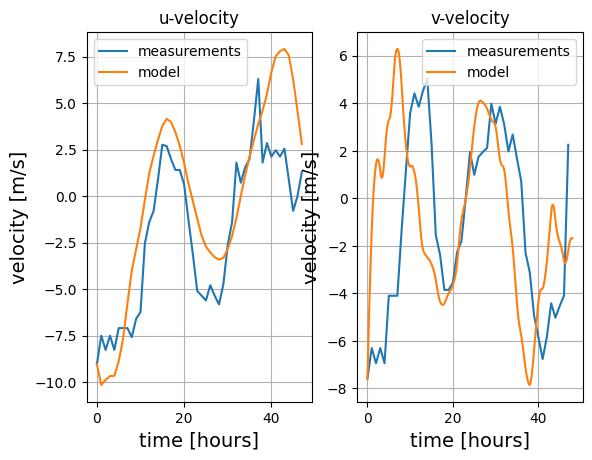

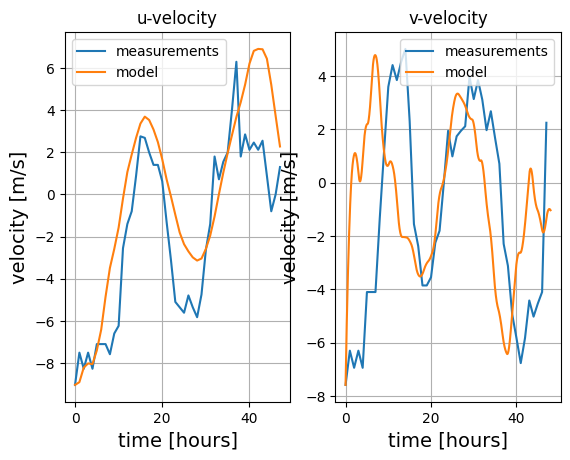

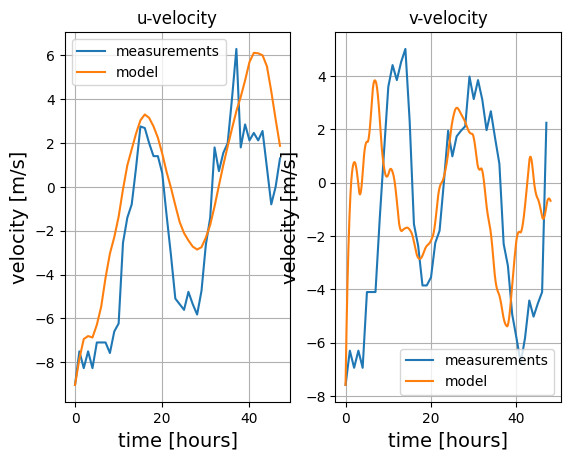

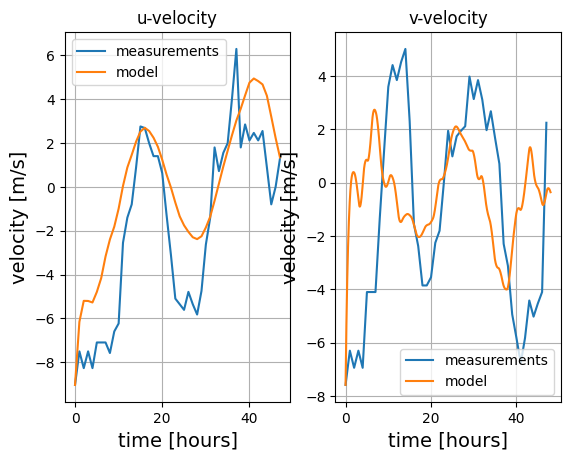

In [20]:
# More sophisticated model
# =============================================================================
# define integration method
dt = 100.
tmax_h = 48 
corrector_step = False
method = "rk4"

integrator = sbm.integration(dt,tmax_h,corrector_step,method)

# define model
lat = -36
A = A_estimate/1000.   # 0.0015
phase = phase_estimate  #-85./(2*np.pi)
gamma = np.array([0.00015,0.0002,0.00025,0.0003,0.0004])

# time array
hours_arr = np.linspace(0.,47.,integrator.iters,endpoint=True)

# array of the pressure gradient
dpdx_synoptic = linfit(hours_arr,poptlin[0],poptlin[1]) + dpdx_mean
dpdy = f_dpdy(hours_arr)

# array for the model standard deviation and correlation coefficent with the measurements
modelstd,corrcoef = map(lambda x: np.zeros_like(x), [gamma,gamma])

# run the model for various gamma
for i in range(len(gamma)):
    # make a model instance
    sb = sbm.seaBreezeModel(lat,A,phase,gamma[i],dpdx_synoptic/1000., dpdy/1000.)
    
    # inital values of the wind field
    u_init = u_vel[0]
    v_init = v_vel[0]
    
    # integrate the model
    integrator.integrate2D(sb.f,sb.ug, sb.vg, u_init,v_init)
    
    # store variabels
    u_model,v_model,time_model = integrator.u,integrator.v, integrator.time    
    
    
    # compute standard deviation and correlation coefficent
    modelstd[i] = np.std(u_model)
    corrcoef[i] = np.corrcoef(u_vel,u_model[::36])[0,1]
    
    # =============================================================================
    # Plots
    # =============================================================================
    
    fig, ax = plt.subplots(1,2)
    ax[0].set_title("u-velocity")
    ax[0].plot(hours,u_vel,label="measurements")
    ax[0].plot(time_model[::36]/3600.,u_model[::36],label="model")
    ax[0].set_xlabel('time [hours]', fontsize=14) # label along x-axes
    ax[0].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
    ax[0].legend()
    ax[0].grid()
    
    ax[1].set_title("v-velocity")
    ax[1].plot(hours,v_vel,label="measurements")
    ax[1].plot(time_model/3600.,v_model,label="model")
    ax[1].set_xlabel('time [hours]', fontsize=14) # label along x-axes
    ax[1].set_ylabel('velocity [m/s]', fontsize=14) # label along x-axes
    ax[1].legend()
    ax[1].grid()
    